# Dataset Overview

let check overview of the dataset.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')

In [3]:
train_df.drop_duplicates(inplace=True)

In [4]:
# train_df.head().T

In [5]:
#Target Distribution
# train_df['class'].value_counts()

In [6]:
#Data Summary
# train_df.describe(include='all').T

# Clean Dataset
Dataset contain a lot of contrived values and so let try clean and see the result.

In [7]:
#get outlier limit
def get_outlier_range(sr):
    Q3 = sr.quantile(0.75)
    Q1 = sr.quantile(0.25)
    IQR = Q3-Q1
    upper = Q3+(1.5*IQR)
    lower = Q1-(1.5*IQR)
    return lower,upper


#let define some helper function
def clean_data(df):
    #feature columns
    if 'class' in df.columns:
        df = df.drop(columns=['id','veil-type'])
        feat_cols = df.drop(columns=['class']).columns

#         modify target data to numerical 
        df['class'],_ = df['class'].factorize()
        
    else:
        df = df.drop(columns=['veil-type'])
        feat_cols = df.drop(columns='id').columns
    
    #category columns
    cat_cols = set([x if y=='object' else np.nan for x,y in zip(feat_cols,df[feat_cols].dtypes)])
    cat_cols.remove(np.nan)
    cat_cols = list(cat_cols)
    cat_cols.sort()
    
    #numerial columns
    num_cols = df[feat_cols].drop(columns=cat_cols).columns
    
    #replace missing values with np.nan
    df = df.fillna(np.nan)
    
    
    #get dictionay of relevant values 
    values ={}
    for col in cat_cols:
#         values[col] = list(df[col].value_counts().apply(lambda x : x if x >100 else np.nan).dropna().index)+['missing']
        values[col] = list(df[col].value_counts().apply(lambda x : x if x >100 else np.nan).dropna().index)+[np.nan]
        

    #modify values with non-relevant values
    for col in cat_cols:
#         df[col] = df[col].fillna('missing')
        df.loc[~df[col].isin(values[col]),col]=np.nan
    
#     #get upper_limit values
#     upper_list = {}
#     for col in num_cols:
#         _,upper_list[col]= get_outlier_range(df[col])

        
        
    #remove rows with outlier values
    for col in num_cols:
        df[col] = pd.qcut(df[col],7,duplicates='drop')
        
#     for col in feat_cols:
#         df[col],_ = pd.factorize(df[col],use_na_sentinel=True)
    

#     one_hot = pd.get_dummies(df[feat_cols],dummy_na=False,dtype=np.uint8)
#     df = pd.concat([df.drop(columns=feat_cols),one_hot],axis=1)


    return df


#check data status
def check_data(df):  
    
    #feature columns
    feat_cols = df.drop(columns=['class','id']).columns
    
    #category columns
    cat_cols = set([x if y=='object' else np.nan for x,y in zip(feat_cols,df[feat_cols].dtypes)])
    cat_cols.remove(np.nan)
    cat_cols = list(cat_cols)
    cat_cols.sort()
    
    
    print('### Null Value Counts ###')
    print(df.isnull().sum())
    
    print('### Feature Summary ###')
    for col in feat_cols:
        display(pd.DataFrame(df[col].value_counts()).T)
    
    print('### Numerical Columns Summary ###')
    df[list(num_cols)].describe()


# Pre-process Data

In [8]:
train  = clean_data(train_df)

In [9]:
col_list = list(train.columns)

In [10]:
train.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,"(7.84, 9.95]",f,s,u,f,a,c,w,"(3.92, 4.84]","(14.55, 18.91]",NaN,NaN,w,NaN,f,f,NaN,d,a
1,1,"(3.55, 4.84]",x,h,o,f,a,c,n,"(3.92, 4.84]","(5.71, 7.81]",NaN,y,o,NaN,t,z,NaN,d,w
2,0,"(6.41, 7.84]",f,s,b,f,x,c,w,"(6.17, 7.11]","(7.81, 11.56]",NaN,s,n,NaN,f,f,NaN,l,w
3,0,"(3.55, 4.84]",f,y,g,f,s,NaN,g,"(3.92, 4.84]","(5.71, 7.81]",NaN,NaN,w,NaN,f,f,NaN,d,u
4,0,"(4.84, 6.41]",x,l,w,f,d,NaN,w,"(-0.001, 3.92]","(7.81, 11.56]",NaN,NaN,w,NaN,f,f,NaN,g,a


In [11]:
from sklearn.model_selection import train_test_split
trainX,testX,trainY,testY = train_test_split(train.drop(columns=['class']),train['class'],test_size=0.2,shuffle=True,stratify=train['class'])

## YDF Model

In [12]:
!pip install ydf -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 24.4 MB/s eta 0:00:0000:0100:01


In [13]:
import ydf

In [14]:
# model = ydf.GradientBoostedTreesLearner(label="class",allow_na_conditions=False,categorical_algorithm='RANDOM',
#                                         num_trees=1500,loss='BINARY_FOCAL_LOSS',max_depth=30,winner_take_all=True,
#                                        growing_strategy='BEST_FIRST_GLOBAL',split_axis='SPARSE_OBLIQUE',
#                                         sparse_oblique_normalization='MIN_MAX'
#                                        ).train(train)

model = ydf.RandomForestLearner(label="class",allow_na_conditions=False,categorical_algorithm='CART',
                                        num_trees=300,max_depth=30
                                       ).train(train)

max_vocab_count = -1 for column class, the dictionary will not be pruned by size.


Train model on 3116945 examples


Data spec:
Number of records: 3116945
Number of columns: 20

Number of columns by type:
	CATEGORICAL: 20 (100%)

Columns:

CATEGORICAL: 20 (100%)
	0: "class" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"1" 1705396 (54.7137%) dtype:DTYPE_INT64
	1: "cap-diameter" CATEGORICAL has-dict vocab-size:8 num-oods:4 (0.000128331%) most-frequent:"(0.028999999999999998, 2.44]" 447494 (14.3568%) dtype:DTYPE_BYTES
	2: "cap-shape" CATEGORICAL num-nas:567 (0.0181909%) has-dict vocab-size:8 zero-ood-items most-frequent:"x" 1436026 (46.08%) dtype:DTYPE_BYTES
	3: "cap-surface" CATEGORICAL num-nas:671625 (21.5475%) has-dict vocab-size:12 zero-ood-items most-frequent:"t" 460777 (18.8432%) dtype:DTYPE_BYTES
	4: "cap-color" CATEGORICAL num-nas:367 (0.0117743%) has-dict vocab-size:13 zero-ood-items most-frequent:"n" 1359542 (43.6229%) dtype:DTYPE_BYTES
	5: "does-bruise-or-bleed" CATEGORICAL num-nas:117 (0.00375368%) has-dict vocab-size:3 zero-ood-items most-frequent:"f" 2569743 (82.4474%) dt

Model trained in 0:46:57.174568


# Cross Validation

In [ ]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import matthews_corrcoef

# skfold = StratifiedKFold(n_splits=5,shuffle=True, random_state=123)
# X=train.drop(columns=['class'])
# Y=train['class']

# model_list=[]
# score_list=[]

# for fold,(train_id,test_id) in enumerate(skfold.split(X,Y)):
#     trainX, trainY = X.iloc[train_id, :], Y[train_id]
#     testX, testY = X.iloc[test_id, :], Y[test_id]
#     model = get_model()
#     model.fit(trainX,trainY,epochs=30,batch_size=256,validation_split=0.2,callbacks=[tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss')])
#     predY = model.predict(testX)
#     predY = [0 if x<=0.5 else 1 for x in predY]
#     mcc_score = matthews_corrcoef(testY,predY)
#     model_list.append(model)
#     score_list.append(mcc_score)
#     print(f"--- Fold {fold+1} MCC Score: {mcc_score:.6f}")

# Evaluate Model

In [15]:
y_pred_raw = model.predict(testX)

Model loaded with 300 root(s), 14246738 node(s), and 19 input feature(s).
Engine "RandomForestOptPred" built


In [16]:
from sklearn.metrics import matthews_corrcoef
y_pred = [0 if x<=0.5 else 1 for x in y_pred_raw]
matthews_corrcoef(testY,y_pred)

0.9861230719991856

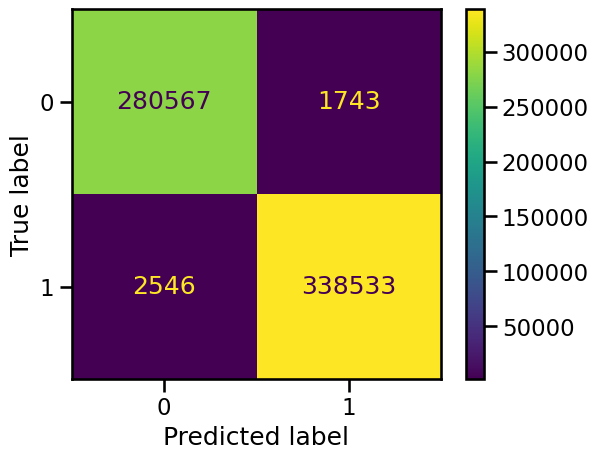

In [17]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
cf = confusion_matrix(testY, y_pred)
sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf)
disp.plot()
plt.show()

# Submission

In [18]:
#pre-process data
test = clean_data(test_df)

In [19]:
test.head()

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,"(7.84, 9.95]",x,NaN,n,t,NaN,NaN,w,"(8.61, 57.29]","(14.55, 18.87]",b,NaN,w,w,t,g,NaN,d,a
1,3116946,"(6.41, 7.84]",o,t,o,f,NaN,c,y,"(-0.001, 3.92]","(7.8, 11.56]",NaN,NaN,n,NaN,f,f,NaN,d,a
2,3116947,"(-0.001, 2.43]",b,g,n,f,NaN,c,n,"(6.17, 7.11]","(2.73, 5.71]",NaN,NaN,n,NaN,f,f,NaN,d,s
3,3116948,"(2.43, 3.54]",x,t,n,f,s,c,n,"(4.84, 5.54]","(7.8, 11.56]",NaN,NaN,w,n,t,z,NaN,d,u
4,3116949,"(4.83, 6.41]",x,h,y,f,p,NaN,y,"(6.17, 7.11]","(11.56, 14.55]",NaN,NaN,y,y,t,NaN,NaN,d,u


In [20]:
# pred =[]
# for model in model_list:
#     pred.append([0 if x<=0.5 else 1 for x in model.predict(test.drop(columns=['id'])).squeeze()])

In [21]:
# sub = pd.DataFrame(['p' if x==1 else 'e' for x in np.median(pred,axis=0) ],index=test['id'],columns=['class'])
# sub.to_csv('submission.csv')

NameError: name 'pred' is not defined

In [22]:
pred = model.predict(test)

In [23]:
sub = pd.DataFrame(['p' if x>=0.5 else 'e' for x in pred ],index=test['id'],columns=['class'])
sub.to_csv('submission.csv')

In [24]:
pred

array([0.00333333, 0.9933325 , 0.72333276, ..., 0.7833327 , 0.04      ,
       0.01333333], dtype=float32)

In [25]:
!head submission.csv

id,class
3116945,e
3116946,p
3116947,p
3116948,p
3116949,e
3116950,e
3116951,e
3116952,p
3116953,p
